In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

In [ ]:
# Load your cleaned data
df = pd.read_csv('../processed_data/merged_data_2017-2021.csv')

# Basic exploration
print(f"Dataset shape: {df.shape}")
print(f"Counties: {df['county'].nunique()}")
print(f"Years: {df['year'].unique()}")
print(df.describe())

In [26]:
#print(df.columns)

In [25]:
# 1. Which counties have the worst air quality?
worst_aqi = df.groupby('county')['median_aqi'].mean().sort_values(ascending=False).head(10)
print("Counties with highest median AQI:")
print(worst_aqi)

# 2. Which counties have highest asthma rates?
high_asthma = df.groupby('county')['asthma_rate'].mean().sort_values(ascending=False).head(10)

# 3. What's the correlation? (pearson's correlation coefficient)
correlation = df['median_aqi'].corr(df['asthma_rate'])
print(f"Correlation between AQI and Asthma rates: {correlation:.3f}")

# 4. Statistical significance (linear regression on the data)
slope, intercept, r_value, p_value, std_err = stats.linregress(df['median_aqi'], df['asthma_rate'])
print(f"R-squared: {r_value**2:.3f}, P-value: {p_value:.3f}")

Counties with highest median AQI:
county
San Bernardino    86.8
Riverside         85.4
Kern              81.0
Los Angeles       78.6
Tulare            77.6
Fresno            71.4
San Diego         68.4
Kings             66.8
Imperial          61.8
Madera            58.8
Name: median_aqi, dtype: float64
Correlation between AQI and Asthma rates: 0.026
R-squared: 0.001, P-value: 0.671


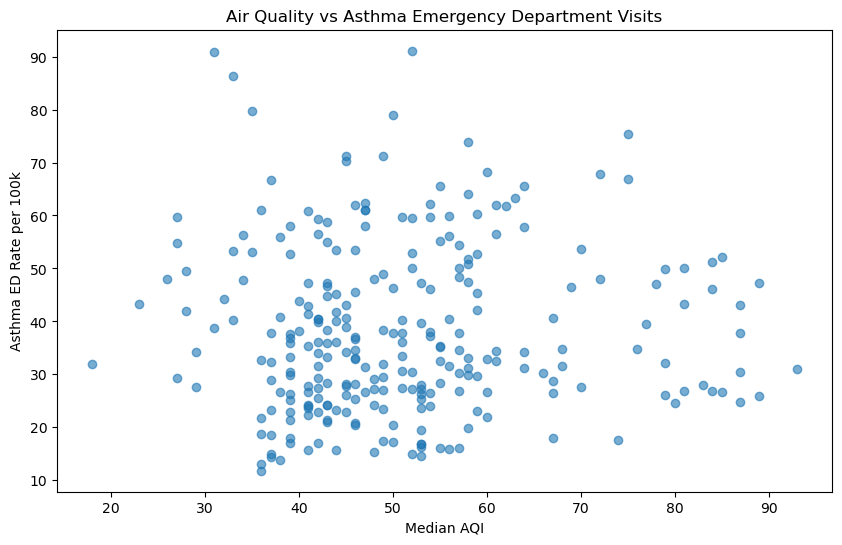

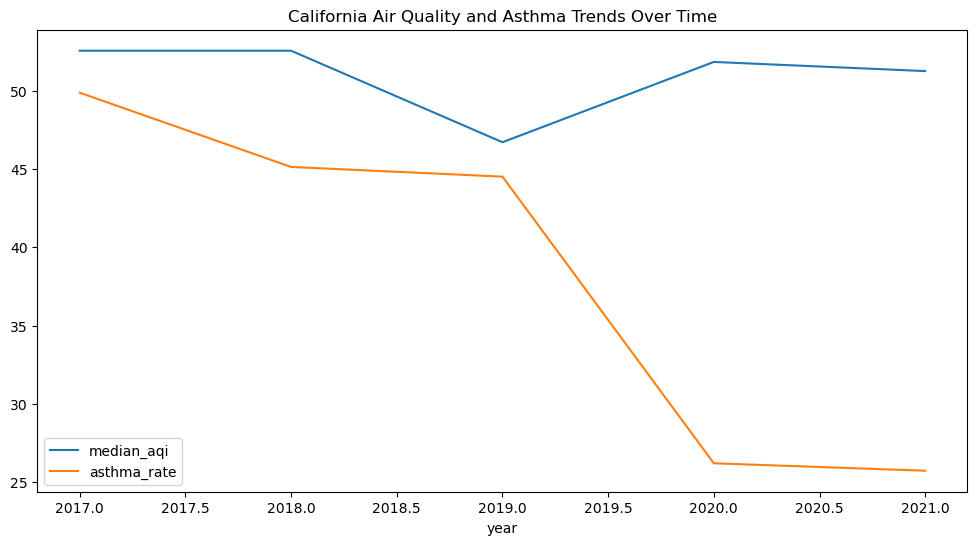

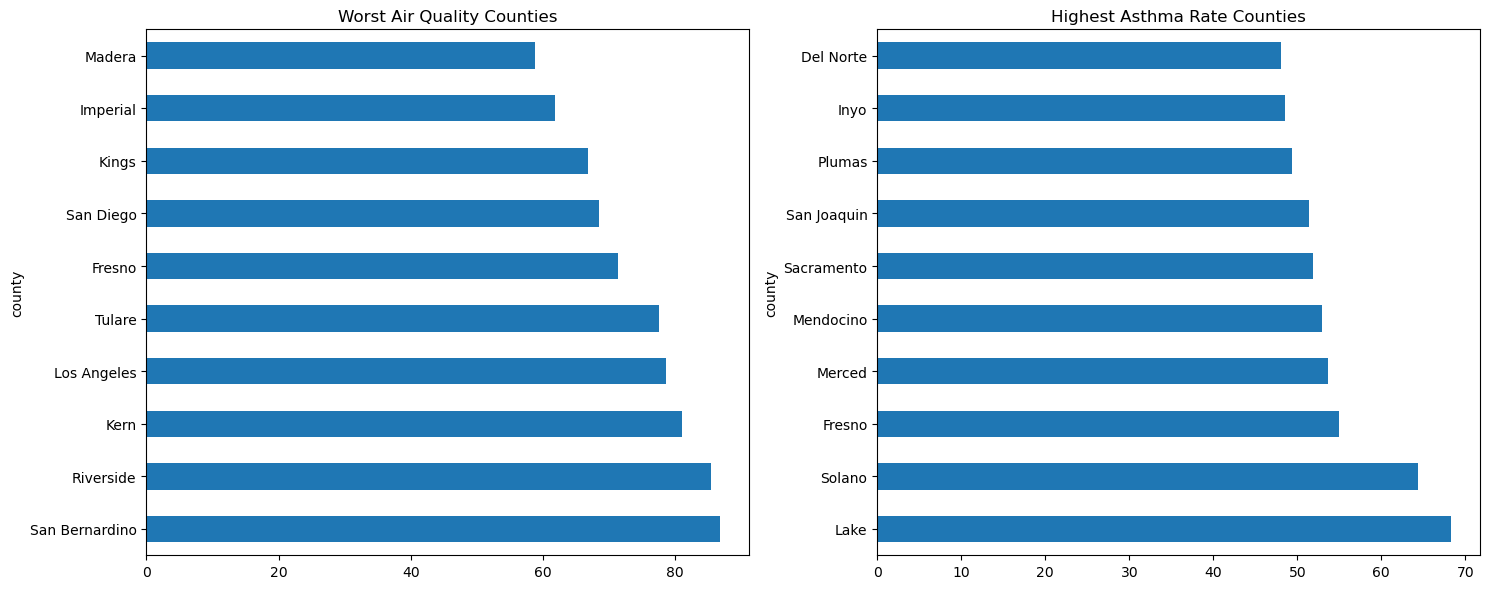

In [7]:
# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df['median_aqi'], df['asthma_rate'], alpha=0.6)
plt.xlabel('Median AQI')
plt.ylabel('Asthma ED Rate per 100k')
plt.title('Air Quality vs Asthma Emergency Department Visits')
plt.show()

# Time trends
yearly_trends = df.groupby('year')[['median_aqi', 'asthma_rate']].mean()
yearly_trends.plot(kind='line', figsize=(12, 6))
plt.title('California Air Quality and Asthma Trends Over Time')
plt.show()

# Top/bottom counties
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
worst_aqi.head(10).plot(kind='barh', ax=ax1, title='Worst Air Quality Counties')
high_asthma.head(10).plot(kind='barh', ax=ax2, title='Highest Asthma Rate Counties')
plt.tight_layout()
plt.show()

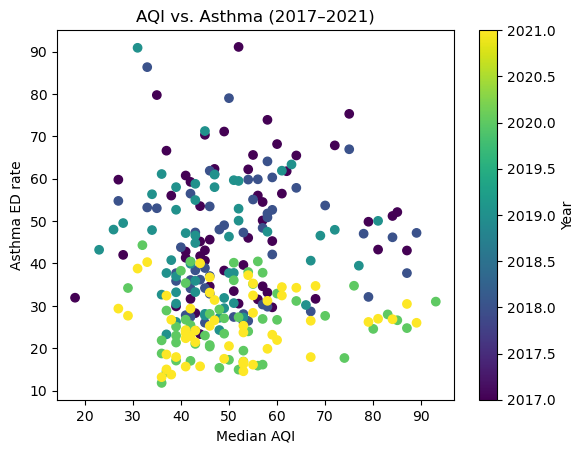

In [24]:
import matplotlib.pyplot as plt

plt.scatter(df['median_aqi'], df['asthma_rate'], c=df['year'])
plt.xlabel('Median AQI')
plt.ylabel('Asthma ED rate')
plt.title('AQI vs. Asthma (2017–2021)')
plt.colorbar(label='Year')
plt.show()

In [4]:
df = pd.read_csv("../processed_data/merged_data_2013-2022.csv")
df = df.drop(columns=["Unnamed: 0"])

# Add constant manually
X = sm.add_constant(df["median_aqi"])
y = df["asthma_rate"]

poisson_model = sm.GLM(y, X, family=sm.families.Poisson()).fit()
print(poisson_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            asthma_rate   No. Observations:                  529
Model:                            GLM   Df Residuals:                      527
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3079.6
Date:                Mon, 23 Jun 2025   Deviance:                       3241.0
Time:                        18:01:58   Pearson chi2:                 3.29e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.07249
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.6053      0.024    149.926      0.0

In [7]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# load the merged data you already produced
df = pd.read_csv("../processed_data/merged_data_2013-2022.csv").drop(columns=["Unnamed: 0"], errors="ignore")

# 1) OLS
ols = smf.ols("asthma_rate ~ median_aqi", data=df).fit()
print("OLS:\n", ols.summary(), "\n")

# 2) Poisson
X = sm.add_constant(df["median_aqi"])
y = df["asthma_rate"]
pois = sm.GLM(y, X, family=sm.families.Poisson()).fit()
print("Poisson:\n", pois.summary(), "\n")

# e.g. “high” if rate is above the median rate
# 3) Logistic
df["high_asthma"] = (df["asthma_rate"] > df["asthma_rate"].median()).astype(int)
logit = smf.logit("high_asthma ~ median_aqi", data=df).fit()
print("Logit:\n", logit.summary())

OLS:
                             OLS Regression Results                            
Dep. Variable:            asthma_rate   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     6.446
Date:                Mon, 23 Jun 2025   Prob (F-statistic):             0.0114
Time:                        18:18:19   Log-Likelihood:                -2225.4
No. Observations:                 529   AIC:                             4455.
Df Residuals:                     527   BIC:                             4463.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     36.3234      2.554     14.221   